In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import math
import anyterrain as at

### Create a world consisting of multiple planes. 

The result is a 2-D matrix *terrain*. Each line of the matrix represent a plane 

$$ax+by+cz+d=0$$

A line of the *terrain* matrix is 

$$[a, b, c, d, x_{min}, x_{max}, y_{min}, y_{max}, \sigma]$$

where $\sigma$ is the covariance of the plane

[[ 0.    0.    1.    0.    0.   10.    0.    5.    0.1 ]
 [ 0.    0.    1.   -3.    0.   10.   10.   20.    0.1 ]
 [ 0.    0.    1.   -0.15  1.    3.    5.    5.25  1.  ]
 [ 0.    0.    1.   -0.3   1.    3.    5.25  5.5   1.  ]
 [ 0.    0.    1.   -0.45  1.    3.    5.5   5.75  1.  ]
 [ 0.    0.    1.   -0.6   1.    3.    5.75  6.    1.  ]
 [ 0.    0.    1.   -0.75  1.    3.    6.    6.25  1.  ]
 [ 0.    0.    1.   -0.9   1.    3.    6.25  6.5   1.  ]
 [ 0.    0.    1.   -1.05  1.    3.    6.5   6.75  1.  ]
 [ 0.    0.    1.   -1.2   1.    3.    6.75  7.    1.  ]
 [ 0.    0.    1.   -1.35  1.    3.    7.    7.25  1.  ]
 [ 0.    0.    1.   -1.5   1.    3.    7.25  7.5   1.  ]
 [ 0.    0.    1.   -1.65  1.    3.    7.5   7.75  1.  ]
 [ 0.    0.    1.   -1.8   1.    3.    7.75  8.    1.  ]
 [ 0.    0.    1.   -1.95  1.    3.    8.    8.25  1.  ]
 [ 0.    0.    1.   -2.1   1.    3.    8.25  8.5   1.  ]
 [ 0.    0.    1.   -2.25  1.    3.    8.5   8.75  1.  ]
 [ 0.    0.    1.   -2.4   1.  

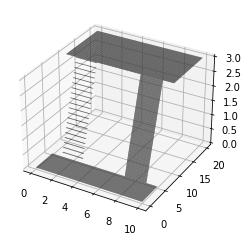

In [2]:
fig = plt.figure(1)
ax = fig.gca(projection='3d')
terrain = at.Terrain(ax,0)
print(terrain.terrainPlanes)

### Create a point cloud in the format of Python dictionary. 

The key is a tuple $(x,y)$ which is the position of the point. The content of the item is the corresponding altitude $z$ and covariance $\sigma$ 

In this way, the environment is discretized.

In [3]:
class Point:
    def __init__(self,z,sigma):
        self.z = z
        self.sigma = sigma

def generatePointCloud(terrainPlanes):
    X = np.arange(0,10,0.1)
    Y = np.arange(0,20,0.1)
    X = np.append(X,10)
    Y = np.append(Y,20)
    pointCloud = {}
    
    for x in X:
        for y in Y:
            x = round(x,2)
            y = round(y,2)
            for i in range(terrainPlanes.shape[0]):
                if terrainPlanes[i,4] <= x < terrainPlanes[i,5] and terrainPlanes[i,6] <= y < terrainPlanes[i,7]:
                    pointCloud[(x,y)] = Point((-terrainPlanes[i,3]-terrainPlanes[i,0]*x-terrainPlanes[i,1]*y)/terrainPlanes[i,2],terrainPlanes[i,8])
                    if x == 2 and y == 5:
                        print(i)
                        print((-terrainPlanes[i,3]-terrainPlanes[i,0]*x-terrainPlanes[i,1]*y)/terrainPlanes[i,2])
            
                    break
    return pointCloud
                    
pointCloud = generatePointCloud(terrain.terrainPlanes)
testX = 2
testY = 4.9
print("The Z of the point ({},{}) is {}. Its sigma is {}".format(testX,testY,pointCloud[(testX,testY)].z,pointCloud[(testX,testY)].sigma))

2
0.15
The Z of the point (2,4.9) is -0.0. Its sigma is 0.1


### Define Anymal state node
This node will be the basic element in the $A^*$ search tree. It records each node's $f$, $g$, $h$ and its parent. They will consist an element in the $A^*$ search tree. The key is $(x,y,z,\theta,\gamma)$

In [4]:
class AnymalStateNode:
    def __init__(self,parentIndex,g,h):
        self.parent = parentIndex
        self.g = g
        self.h = h
        self.f = g + h

### $A^*$ algorithm

In [5]:
class AnymalAStar:
    def __init__(self,pointCloud,start,goal):
        self.pointCloud = pointCloud
        self.start = start
        self.goal = goal
        self.openList = {}
        self.closedList = {}
        print("The start node is {}".format(self.start))
        print("The goal node is {}".format(self.goal))
        
    def run(self):
        # add the start point to the open list. Its g = 0, h is an estimate distance towards the goal
        self.openList[self.start] = AnymalStateNode(self.start,0,self.getH(self.start))
        
        numSearchTimes = 0
        
        while len(self.openList) > 0:
            # find the minimum element and stand on it. Then, search its children          
            currentNode = self.moveToMinNode()
            numSearchTimes = numSearchTimes + 1
            if self.searchChildren(currentNode):
                print("A* finished")
                break
        #print(self.closedList)
    
    # Based on current node, we search its possible children (feasible nodes) and add valid children to
    # the open list and do the loop until we reach the goal
    def searchChildren(self,currentNode):
        #print("searchChildren is running")
        numOfValidChildren = 0
        actions = [(deltaX,deltaY,gamma) for deltaX in [-0.1,0,0.1] for deltaY in [0.1,0.2] for gamma in [0,1]]
        
        for act in actions:
            actionValid,child = self.checkAction(currentNode,act)
            
            if actionValid == False:
                continue
            # Here we have found a valid child of the current node. We need to check if this child is 
            # already in the open list or closed list
            if child in self.closedList:
                if currentNode[0] == testX and currentNode[1] == testY:
                    print("The child {} is in the closedList".format(child))
                continue
            elif child in self.openList:
                # Check if we need to change the child's parent
                if currentNode[0] == testX and currentNode[1] == testY:
                    print("The child {} is in the openList".format(child))
                if self.openList[child].g > self.getG(currentNode,child,act):
                    self.openList[child].parent = currentNode
                    self.openList[child].g = self.getG(currentNode,child,act)
                    self.openList[child].f = self.openList[child].g + self.openList[child].h
            else:
                if currentNode[0] == testX and currentNode[1] == testY:
                    print("Add the child {} to the openList".format(child))
                self.openList[child] = AnymalStateNode(currentNode,self.getG(currentNode,child,act),self.getH(child))
                
            if child == self.goal:
                print("Found the path")
                print(child)
                self.closedList[child] = copy.deepcopy(self.openList[child])
                self.openList.pop(child)
                return True
        return False
        
        
        
    # This is the the heuristic of the A*. In this situation, it is the estmation distance between
    # the node and the goal. In theory, it should be less than the real distance which can help A* 
    # converge to the optimal result
    def getH(self,node):
        return math.sqrt((node[0] - self.goal[0])**2 + (node[1] - self.goal[1])**2)
    
    
    # This function finds the node with minumum score in the open list
    # Once it is found, it will be moved to the closed list, which means we stand on this node
    def moveToMinNode(self):
        # NOTE: use deepcopy to move elements from dict1 to dict2!! Otherwise, it is just a link
        minIndex = min(self.openList, key=lambda p: self.openList[p].f)
        self.closedList[minIndex] = copy.deepcopy(self.openList[minIndex])
        self.openList.pop(minIndex)
        
        if minIndex[0] == testX and minIndex[1] == testY + 0.1:
            print("The node ({},{}) is added to the closed list".format(minIndex[0],minIndex[1]))
        return minIndex
    
    
    # This function checks if the action can guide the robot from current node to a feasible node in the map
    def checkAction(self,currentNode,action):
        valid = False
        child = ('nan','nan','nan','nan','nan')
        key = (round(currentNode[0]+action[0],2),round(currentNode[1]+action[1],2))
        if key in self.pointCloud.keys():
            if abs(currentNode[2] - self.pointCloud[key].z)<0.3:
                valid = True
                child = (key[0],key[1],self.pointCloud[key].z,0.0,action[2])
            
        return valid, child
    
    
    # This function calculate the g value of the child when there is a movement from the parent to the child
    # When the action is once-touch, the score is just distance + covariance
    # If it is a two-touch action, we penalize the distance by 1.5 and decrease covariance score by 0.1
    # So it is a balance of fast touch and the risk
    def getG(self,parent,child,action):
        key = (child[0],child[1])
        distance = math.sqrt((parent[0] - child[0])**2 + (parent[1] - child[1])**2)
        if action[2] == 0:
            value = distance + self.pointCloud[key].sigma
        elif action[2] == 1:
            value = distance * 1.5 + self.pointCloud[key].sigma * 0.1
        else:
            print("Warning!! invalid action")
        return self.closedList[parent].f + value
        


In [6]:
start = (0.,0.,0.,0.,0.)
goal = (2.,18.,3.,0.,0.)
anyAStar = AnymalAStar(pointCloud,start,goal)
anyAStar.run()

The start node is (0.0, 0.0, 0.0, 0.0, 0.0)
The goal node is (2.0, 18.0, 3.0, 0.0, 0.0)
(1.9, 5.0, 0.15, 0.0, 0)
True
The child (1.9, 5.0, 0.15, 0.0, 0) is in the openList
(1.9, 5.0, 0.15, 0.0, 1)
True
The child (1.9, 5.0, 0.15, 0.0, 1) is in the openList
(1.9, 5.1, 0.15, 0.0, 0)
True
The child (1.9, 5.1, 0.15, 0.0, 0) is in the openList
(1.9, 5.1, 0.15, 0.0, 1)
True
The child (1.9, 5.1, 0.15, 0.0, 1) is in the openList
(2.0, 5.0, 0.15, 0.0, 0)
True
The child (2.0, 5.0, 0.15, 0.0, 0) is in the openList
(2.0, 5.0, 0.15, 0.0, 1)
True
The child (2.0, 5.0, 0.15, 0.0, 1) is in the openList
(2.0, 5.1, 0.15, 0.0, 0)
True
The child (2.0, 5.1, 0.15, 0.0, 0) is in the openList
(2.0, 5.1, 0.15, 0.0, 1)
True
The child (2.0, 5.1, 0.15, 0.0, 1) is in the openList
(2.1, 5.0, 0.15, 0.0, 0)
True
The child (2.1, 5.0, 0.15, 0.0, 0) is in the openList
(2.1, 5.0, 0.15, 0.0, 1)
True
The child (2.1, 5.0, 0.15, 0.0, 1) is in the openList
(2.1, 5.1, 0.15, 0.0, 0)
True
Add the child (2.1, 5.1, 0.15, 0.0, 0) to 

In [8]:
actions = [(deltaX,deltaY,gamma) for deltaX in [-0.1,0.0,0.1] for deltaY in [0.1,0.2] for gamma in [0,1]]
(2.0, 18.0, 3.0, 0.0, 0) == goal

True